## Introduction to DEA Landsat surface reflectance

#### Digital Earth Australia currently contains two Landsat products that differ in their specifications.  This notebook is intended as a quick guide to understanding the specifications and provenance of each product. Each product description includes information on:

* The data processing pipeline used to produce the dataset
* Some important details on each products configurations
* The operational status of each product
* The date range available for each product
* The minimum loading requirements to use with `dc.load` to extract data
* The bands each product contains

## About Landsat 

"Landsat represents the world's longest continuously acquired collection of space-based moderate-resolution land remote sensing data. Four decades of imagery provides a unique resource for those who work in agriculture, geology, forestry, regional planning, education, mapping, and global change research. Landsat images are also invaluable for emergency response and disaster relief." [[1](#References)] 

"In the mid-1960s an ambitious effort to develop and launch the first civilian Earth observation satellite was started. The goal was achieved on July 23, 1972, with the launch of the Earth Resources Technology Satellite (ERTS-1), which was later renamed Landsat 1. The launches of Landsat 2, Landsat 3, and Landsat 4 followed in 1975, 1978, and 1982, respectively. When Landsat 5 was launched in 1984, no one could have predicted that the satellite would continue to deliver high quality, global data of Earth's land surfaces for 28 years and 10 months until its retirement in June, 2013. Landsat 6, however, failed to achieve orbit in 1993. Landsat 7 was successfully launched in 1999 and, along with Landsat 8 launched in 2013, continues to provide daily global data. Landsat 9 is planned to be launched in late 2020." [[2](#References)]

![Fig 1. Time-line of the working lives of Landsats since 1972](data/TimelineOnlyForWebRGB.jpg)


### Basic details about Landsat 5 to 9 [[3](#References)][[4](#References)][[5](#References)][[6](#References)][[7](#References)]

![Fig 2. Basic details about the Landsats](data/landsats.jpg)


#### GA has acquired Landsat imagery over Australia since 1979, including TM, ETM+ and OLI imagery. While this data has been used extensively for numerous land and coastal mapping studies, its utility for accurate monitoring of environmental resources has been limited by the processing methods that have been traditionally used to correct for inherent geometric and radiometric distortions in EO imagery. To improve access to Australia's archive of Landsat TM/ETM+/OLI data, GA has collaboratively developed an integrated approach to image data correction that incorporates normalising models to account for atmospheric effects, BRDF and topographic shading.

#### The sensors on the Landsats are different and collect reflected radiance in various spectral wavelengths. These are called bands. The following bands are included in the DEA archive: band names to be used in code, when retrieving the data, are given in brackets.

- **Landsat 5 and 7:**
    - Excludes Landsat 5 Thematic Mapper (TM) thermal band and Multispectral Scanner (MSS) bands, and Landsat 7 Enhanced Thematic Mapper Plus (ETM+) thermal band and panchromatic band    
    - Includes the following Landsat 5 TM and Landsat 7 ETM+ bands:  
        - Band 1: blue (`blue`)
        - Band 2: green (`green`)
        - Band 3: red (`red`)
        - Band 4: near-infrared (`nir`)
        - Band 5: shortwave infrared 1 (`swir1`)
        - Band 7: shortwave infrared 2 (`swir2`)
- **Landsat 8:**
    - Excludes the Operational Land Imager Thermal Infrared Sensor (TIRS) bands
    - Includes the following Operational Land Imager (OLI) bands:
        - Band 1: coastal aerosol (`coastal_aerosol`)         
        - Band 2: blue (`blue`)
        - Band 3: green (`green`)
        - Band 4: red (`red`)
        - Band 5: near-infrared (`nir`)
        - Band 6: shortwave infrared 1 (`swir1`)
        - Band 7: shortwave infrared 2 (`swir2`)
        - Band 8: panchromatic (`panchromatic`)

#### Landsat 7 Scan Line Corrector failure: "The Scan Line Corrector (SLC) is an electro-optical mechanism composed of two parallel mirrors set at an angle on a shaft. The SLC is positioned behind the primary optics and compensates for the along-track motion of the spacecraft occurring during an active SMA cross-track scan. As a result, a rectilinear scan pattern is produced using the SLC instead of the zigzag pattern that would be produced without it. The SLC failed for Landsat 7 on May 31, 2003. Without an operating SLC, the ETM+ line of sight now traces a zig-zag pattern along the satellite ground track (see the figure above) resulting in wedge shaped scan-to-scan gaps (and alternating overlap areas) which increase in magnitude away from nadir. Despite the SLC failure, Landsat 7 ETM+ is still capable of acquiring useful image data with the SLC turned off (SLC-off), particularly within the central portion of any given scene." [[8](#References)]

#### The top panel in the figure below shows how Landat 7 imagery appears prior to the May 31 2003 SLC failure (i.e. Landsat 7 SLC-on). The bottom panel shows the same area after the SLC failed (i.e. Landsat 7 SLC-off), with obvious diagonal striping that covers approximately 22% of the scene. This striping will be present in all post-May 31 2003 in the DEA archive. For certain applications, it may be best to completely exclude post post-May 31 2003 imagery from analyses.

![Figure 3. Scan line corrected image.](data/SLC_comparison.jpg)

#### The recommended collection to work with Landsat surface reflectance data is the GA Collection 3. This collection exposes the following product names: “ga_ls8c_ard_3”, "ga_ls7e_ard_3", and "ga_ls5t_ard_3", containing data for each satellite mission.

#### In this tutorial we are going to see how to load Collection 3 Landsat data using DEA, plot the data and perform simple analyses.

In [1]:
%matplotlib inline

import sys
import warnings
import datacube
import matplotlib.pyplot as plt
from check_answer import check_answer

dc = datacube.Datacube(app="Landsat")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


#### Specify a *query* with coordinates, date range and the desired NBART measurements:

- **lat/lon:** Latitude and longitude of the area. e.g. Canberra = `'lat': (-35.25, -35.35), 'lon': (149.05, 149.17)`
- **time:** Date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swath boundary, it may be captured in two passes and so there could be two images within the 16 day period.

>Note: Time needs to be in accordance to the availavility of data for each Landsat mission.

In [3]:
# Define temporal and spatial extents to pass to `dc.load` for the data extraction:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'time':('2017-01-01', '2017-01-15')}

#### Load Landsat data: When loading NBAR-T data from the Landsat 8 satellite. Sometimes multiple scenes are acquired by the satellite on the same day. For convenience we can group these together, using the `group_by='solar_day'` option in the `load()` function.

In [4]:
# Load data for the specified query extent using `dc.load`:
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)
ds

<xarray.Dataset>
Dimensions:       (time: 2, x: 492, y: 500)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-07T23:50:29.282085 2017-01-14...
  * y             (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x             (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) int16 1469 1469 1493 1472 ... -999 -999 -999 -999
    nbart_green   (time, y, x) int16 1483 1483 1487 1479 ... -999 -999 -999 -999
    nbart_blue    (time, y, x) int16 1358 1358 1428 1428 ... -999 -999 -999 -999
    nbart_nir     (time, y, x) int16 2170 2170 2212 2207 ... -999 -999 -999 -999
    nbart_swir_1  (time, y, x) int16 1262 1262 1244 1251 ... -999 -999 -999 -999
    nbart_swir_2  (time, y, x) int16 1064 1064 1047 1043 ... -999 -999 -999 -999
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

>Note: Remember Landsat bands are listed under `Data variables`. Surface reflectance values for each of the Landsat bands are expressed as **16-bit integers scaled between 0 and 10000.**

#### Exercise 4.1: Can you get the first value of the time dimension in the previous datacube and assign it to the `answ` variable?

In [9]:
answ = ds.time[0]

#print(answ)
check_answer("DEA4.1", str(answ.values))

'Well done!'

#### Let's plot the `nbart_nir` band for both times using a red colourmap:

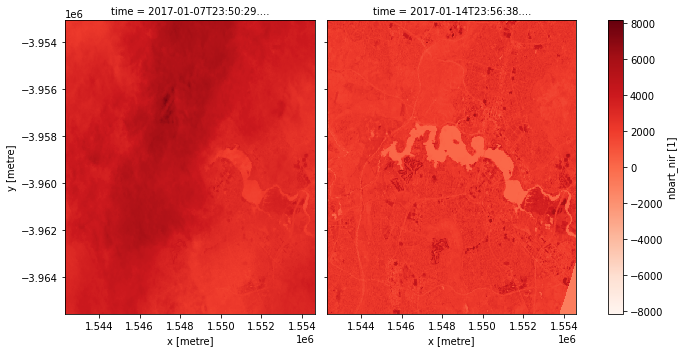

In [10]:
# Make a plot with one column for each time-step:
ds.nbart_nir.plot(col='time', figsize=(10, 5), cmap = 'Reds')

#### We see that the second image contains land surface for most of the area with the exception of the bottom-right corner which coincides with the limits of the swath. However the first image contains clouds that prevent us from seeing most of the Earth's surface.

#### Exercise 4.2: Can you create a true colour image composite of the second image?

> Note: By specifying the `red`, `green` and `blue` bands, we can produce a ['true colour' plot](https://crisp.nus.edu.sg/~research/tutorial/opt_int.htm) that approximates how the landscape would appear to the human eye. Note however that below we use the `robust=True` argument to remove extreme values and result in a colour-enhanced image:

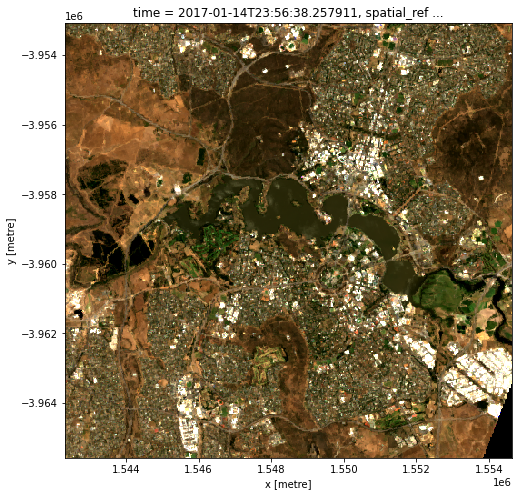

In [13]:
# Select the band names and time from the initial ds variable
answ = ds[["nbart_red","nbart_green","nbart_blue"]].isel(time=1)

answ.to_array().plot.imshow(robust=True, figsize=(8, 8))

#### Bands from Landsat surface reflectance products can be combined to compute simple remote sensing indices that provide insights into different aspects of the observed landscape. For example, we can calculate the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

In [14]:
ds

<xarray.Dataset>
Dimensions:       (time: 2, x: 492, y: 500)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-07T23:50:29.282085 2017-01-14...
  * y             (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x             (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) int16 1469 1469 1493 1472 ... -999 -999 -999 -999
    nbart_green   (time, y, x) int16 1483 1483 1487 1479 ... -999 -999 -999 -999
    nbart_blue    (time, y, x) int16 1358 1358 1428 1428 ... -999 -999 -999 -999
    nbart_nir     (time, y, x) int16 2170 2170 2212 2207 ... -999 -999 -999 -999
    nbart_swir_1  (time, y, x) int16 1262 1262 1244 1251 ... -999 -999 -999 -999
    nbart_swir_2  (time, y, x) int16 1064 1064 1047 1043 ... -999 -999 -999 -999
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [15]:
# Compute NDWI using the formula (green - nir) / (green + nir). 
ds_ndwi = (ds.nbart_green - ds.nbart_nir) / (ds.nbart_green + ds.nbart_nir)

# We can now add this back into our dataset as a new data variable
# sharing dimensions with the rest of the data
ds["NDWI"] = ds_ndwi
ds

<xarray.Dataset>
Dimensions:       (time: 2, x: 492, y: 500)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-07T23:50:29.282085 2017-01-14...
  * y             (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x             (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) int16 1469 1469 1493 1472 ... -999 -999 -999 -999
    nbart_green   (time, y, x) int16 1483 1483 1487 1479 ... -999 -999 -999 -999
    nbart_blue    (time, y, x) int16 1358 1358 1428 1428 ... -999 -999 -999 -999
    nbart_nir     (time, y, x) int16 2170 2170 2212 2207 ... -999 -999 -999 -999
    nbart_swir_1  (time, y, x) int16 1262 1262 1244 1251 ... -999 -999 -999 -999
    nbart_swir_2  (time, y, x) int16 1064 1064 1047 1043 ... -999 -999 -999 -999
    NDWI          (time, y, x) float64 -0.1881 -0.1881 -0.196 ... -0.0 -0.0 -0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Plotting a single data variable or band. Newly created data variables (like `NDWI` above) can be plotted in exactly the same way as individual Landsat bands:

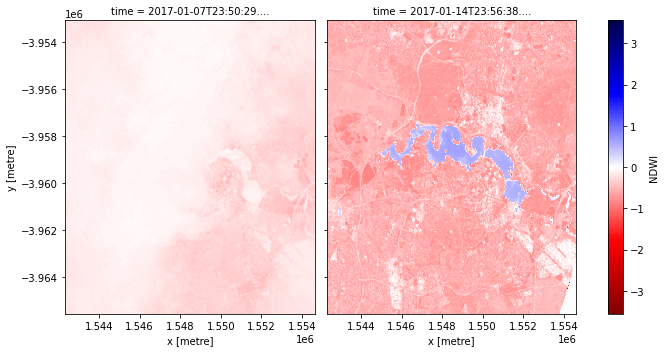

In [19]:
# First, we select the variable we want ('NDWI'), and then make a 
# plot with one column for each time-step:
ds.NDWI.plot(col='time', figsize=(10, 5), cmap='seismic_r'); 

#### Exercise 4.3: Can you add a Normalized Difference Vegetation Index (NDVI) to the same dataset. Call the new variable `NDVI`.

In [ ]:
# Compute NDVI using the formula (nir - red) / (nir + red)
ds_ndvi = ?

# Add this back into our dataset as a new data variable:
ds[?] = ds_ndvi

# Plot:
ds.NDVI.plot(col='time', figsize=(10, 5), cmap='summer_r')

check_answer("DEA4.3", ds.NDVI.shape)

#### Pixel quality with FMask: As we have seen in the previous example, clouds are present in satellite images. The DEA ARD data comes with extra information that we can use to detects and filter these clouds and its related effects.

#### FMask provides an assessment of each image pixel to determine if it is a valid pixel or if its covered by clouds, shadow or water. an unobscured, unsaturated observation of the Earth surface and also whether the pixel is represented in each spectral band. The PQ product allows users to produce masks which can be used to exclude pixels which do not meet their quality criteria from analysis. FMask provides an assessment of the quality of observations at a pixel level, and contains information about whether a pixel is affected by the following.

- Valid pixel
- Presence of snow
- Presence of cloud
- Presence of cloud shadow
- Presence of water 

#### FMask data exactly matches the resolution and projection system of Landsat 5, 7 and 8 data, with 25 square metre grid cells in the same Australian Albers Equal Area (EPSG:3577) projection system as the reflectance data.

#### To load Landsat fmask data we specify a *query* with coordinates and date range and add the `oa_fmask` variable to the list of measurements.

In [24]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2',
                          'oa_fmask'],
         'time':('2015-07-19', '2015-08-15')}

# Load data
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)

ds

<xarray.Dataset>
Dimensions:       (time: 4, x: 492, y: 500)
Coordinates:
  * time          (time) datetime64[ns] 2015-07-20T23:56:03.574952 ... 2015-0...
  * y             (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x             (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) int16 437 437 387 495 662 ... 2248 2217 1812 1793
    nbart_green   (time, y, x) int16 412 412 356 437 648 ... 2109 2177 1753 1742
    nbart_blue    (time, y, x) int16 295 295 266 377 530 ... 2121 2120 1701 1601
    nbart_nir     (time, y, x) int16 1185 1185 1146 1262 ... 3658 3702 3278 3285
    nbart_swir_1  (time, y, x) int16 867 867 730 853 ... 3739 3828 3484 3463
    nbart_swir_2  (time, y, x) int16 668 668 541 661 851 ... 2839 2852 2402 2400
    oa_fmask      (time, y, x) uint8 3 3 1 3 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Exercise 4.4: Click on the file icon on the right of the `oa_fmask` variable to display the metadata. Can you find the value in this mask that designates `valid` pixels?

> Tip: You might need to click on the triangle next to `Data variables:` to open the list variables.

In [21]:
answ = 1

check_answer("DEA4.4", int(answ))

'Well done!'

#### Now let's create an true colour RGB image of the previous request:

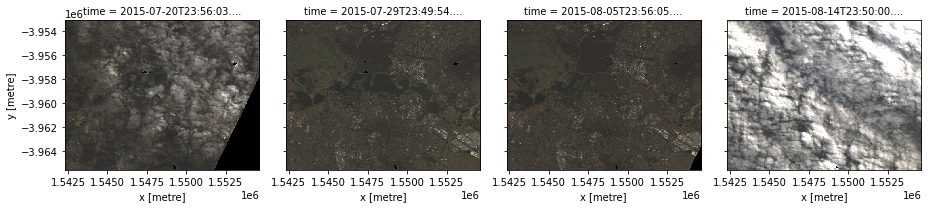

In [26]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True,col='time')

#### As you can see there are many clouds in this image. We are going to use the `oa_fmask` variable in combination with the XArray `.where()` function to filter out all the non valid pixels in the previous image:

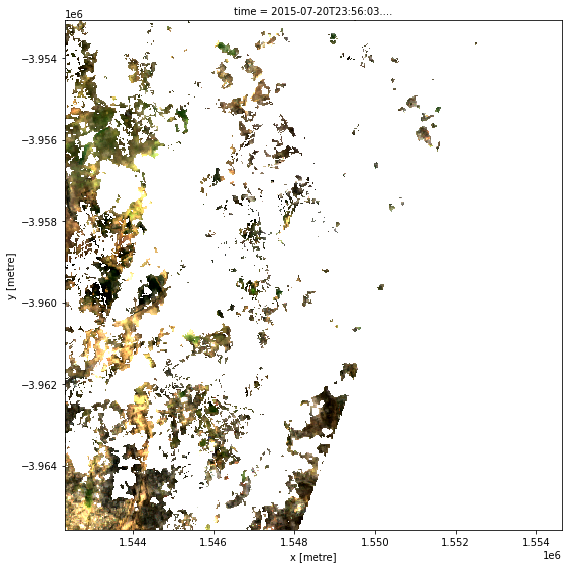

In [23]:
ds[['nbart_red', 'nbart_green', 'nbart_blue']].where(ds.oa_fmask.values==1).to_array().plot.imshow(robust=True,col='time',figsize=(8,8))

#### Exercise 4.5: Can you show a false colour image (red -> nir) in which we only filter the cloud shadows in the previous image?

"Sorry, that doesn't seem right. Think a little bit more and try again"

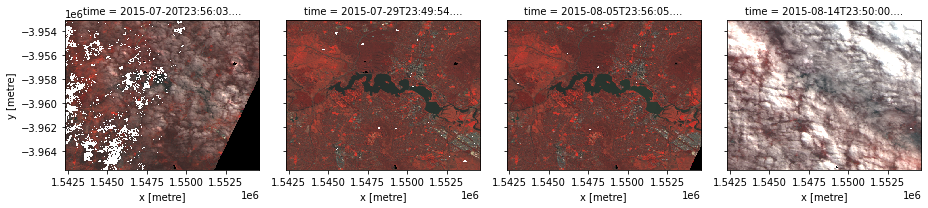

In [30]:
answ = ds[['nbart_nir', 'nbart_green', 'nbart_blue']].where(ds.oa_fmask.values!=3)

answ.to_array().plot.imshow(robust=True, col='time')

check_answer("DEA4.5", int(answ.nbart_nir.mean().values))

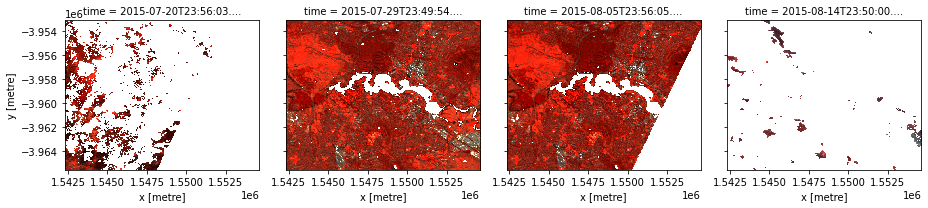

In [32]:
ds.where(ds.oa_fmask.values==1)[['nbart_nir', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True, col='time')

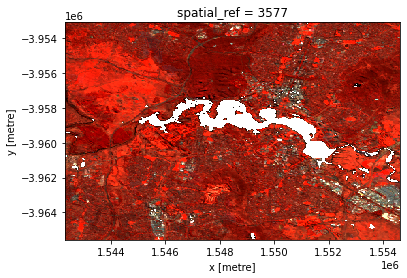

In [40]:
med = ds.where(ds.oa_fmask.values==1).mean(dim='time')

med[['nbart_nir', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True)

#### The other surface reflectance product available in DEA is called: GA Collection 2. This collection exposes the following product names: "ls5_nbar(t)_albers", "ls7_nbar(t)_albers", “ls8_nbar(t)_albers”

#### The data processing pipeline begins with [USGS Level 0 telemetry](https://landsat.usgs.gov/landsat-level-0-samples), and then GA processes the data to NBAR(T) & PQ

#### Important details:
* Surface reflectance product
    * Valid SR scaling: 0 – 10,000
* Spatial resolution is 25 x 25 m
* Albers Equal Area projection (epsg: 3577)
* NBART and NBAR provided as seperate products
* Pixel quality provided as seperate product (GA PQ)
* Pixel alignment is left-edge
* LS7 SLC-off scenes are not interpolated

#### Currently running in parallel with GA Landsat Collection 3, but will eventually be decommissioned when GA Collection 3 has a fully automated ARD pipeline, and the derivative products are produced (WOfS, FC etc).  Only available on the NCI.

#### This data collection currently coverrs the 1987-05 to 2019-12 period and exposes the following measurements:
       
* blue     
* green    
* red    
* nir     
* swir1  
* swir2           

### References

1. USGS, 2018a. *Landsat Project Description | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm. <https://landsat.usgs.gov/landsat-project-description>
2. USGS, 2018b. *Landsat Missions Timeline | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-missions-timeline>
3. USGS, 2018c. *Landsat 5 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-5-history>
4. USGS, 2018d. *Landsat 6 History | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-6-history>
5. USGS, 2018e. *Landsat 7 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-history>
6. USGS, 2018f. *Landsat 8 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-8-mission>
7. USGS, 2018g. *Landsat 9 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-9-mission>
8. USGS, 2018h. *Landsat 7 Data Users Handbook - Section 2 | Landsat Missions*, Page Last Modified: 04/25/18 01:57 pm <https://landsat.usgs.gov/landsat-7-data-users-handbook-section-2>
9. GA, 2017. *Surface Reflectance &mdash; Digital Earth Australia 1.0.0 documentation* <http://geoscienceaustralia.github.io/digitalearthau/data/data.html>

